<a href="https://colab.research.google.com/github/wuhyyy/TKAN-AE/blob/main/%E2%80%9C%E2%80%9C%E2%80%9CTransformer_AE_anomaly_detection_ipynb%E2%80%9Dpaper%E2%80%9D%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Dec 24 07:52:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              27W /  70W |    947MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install gdown
#!pip install transformers
#!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
#from transformers import InformerConfig, InformerModel
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PrxHkSQGBKoWJk4ec55gHC9-Mtj6s6ra
To: /content/spx.csv
100% 190k/190k [00:00<00:00, 122MB/s]


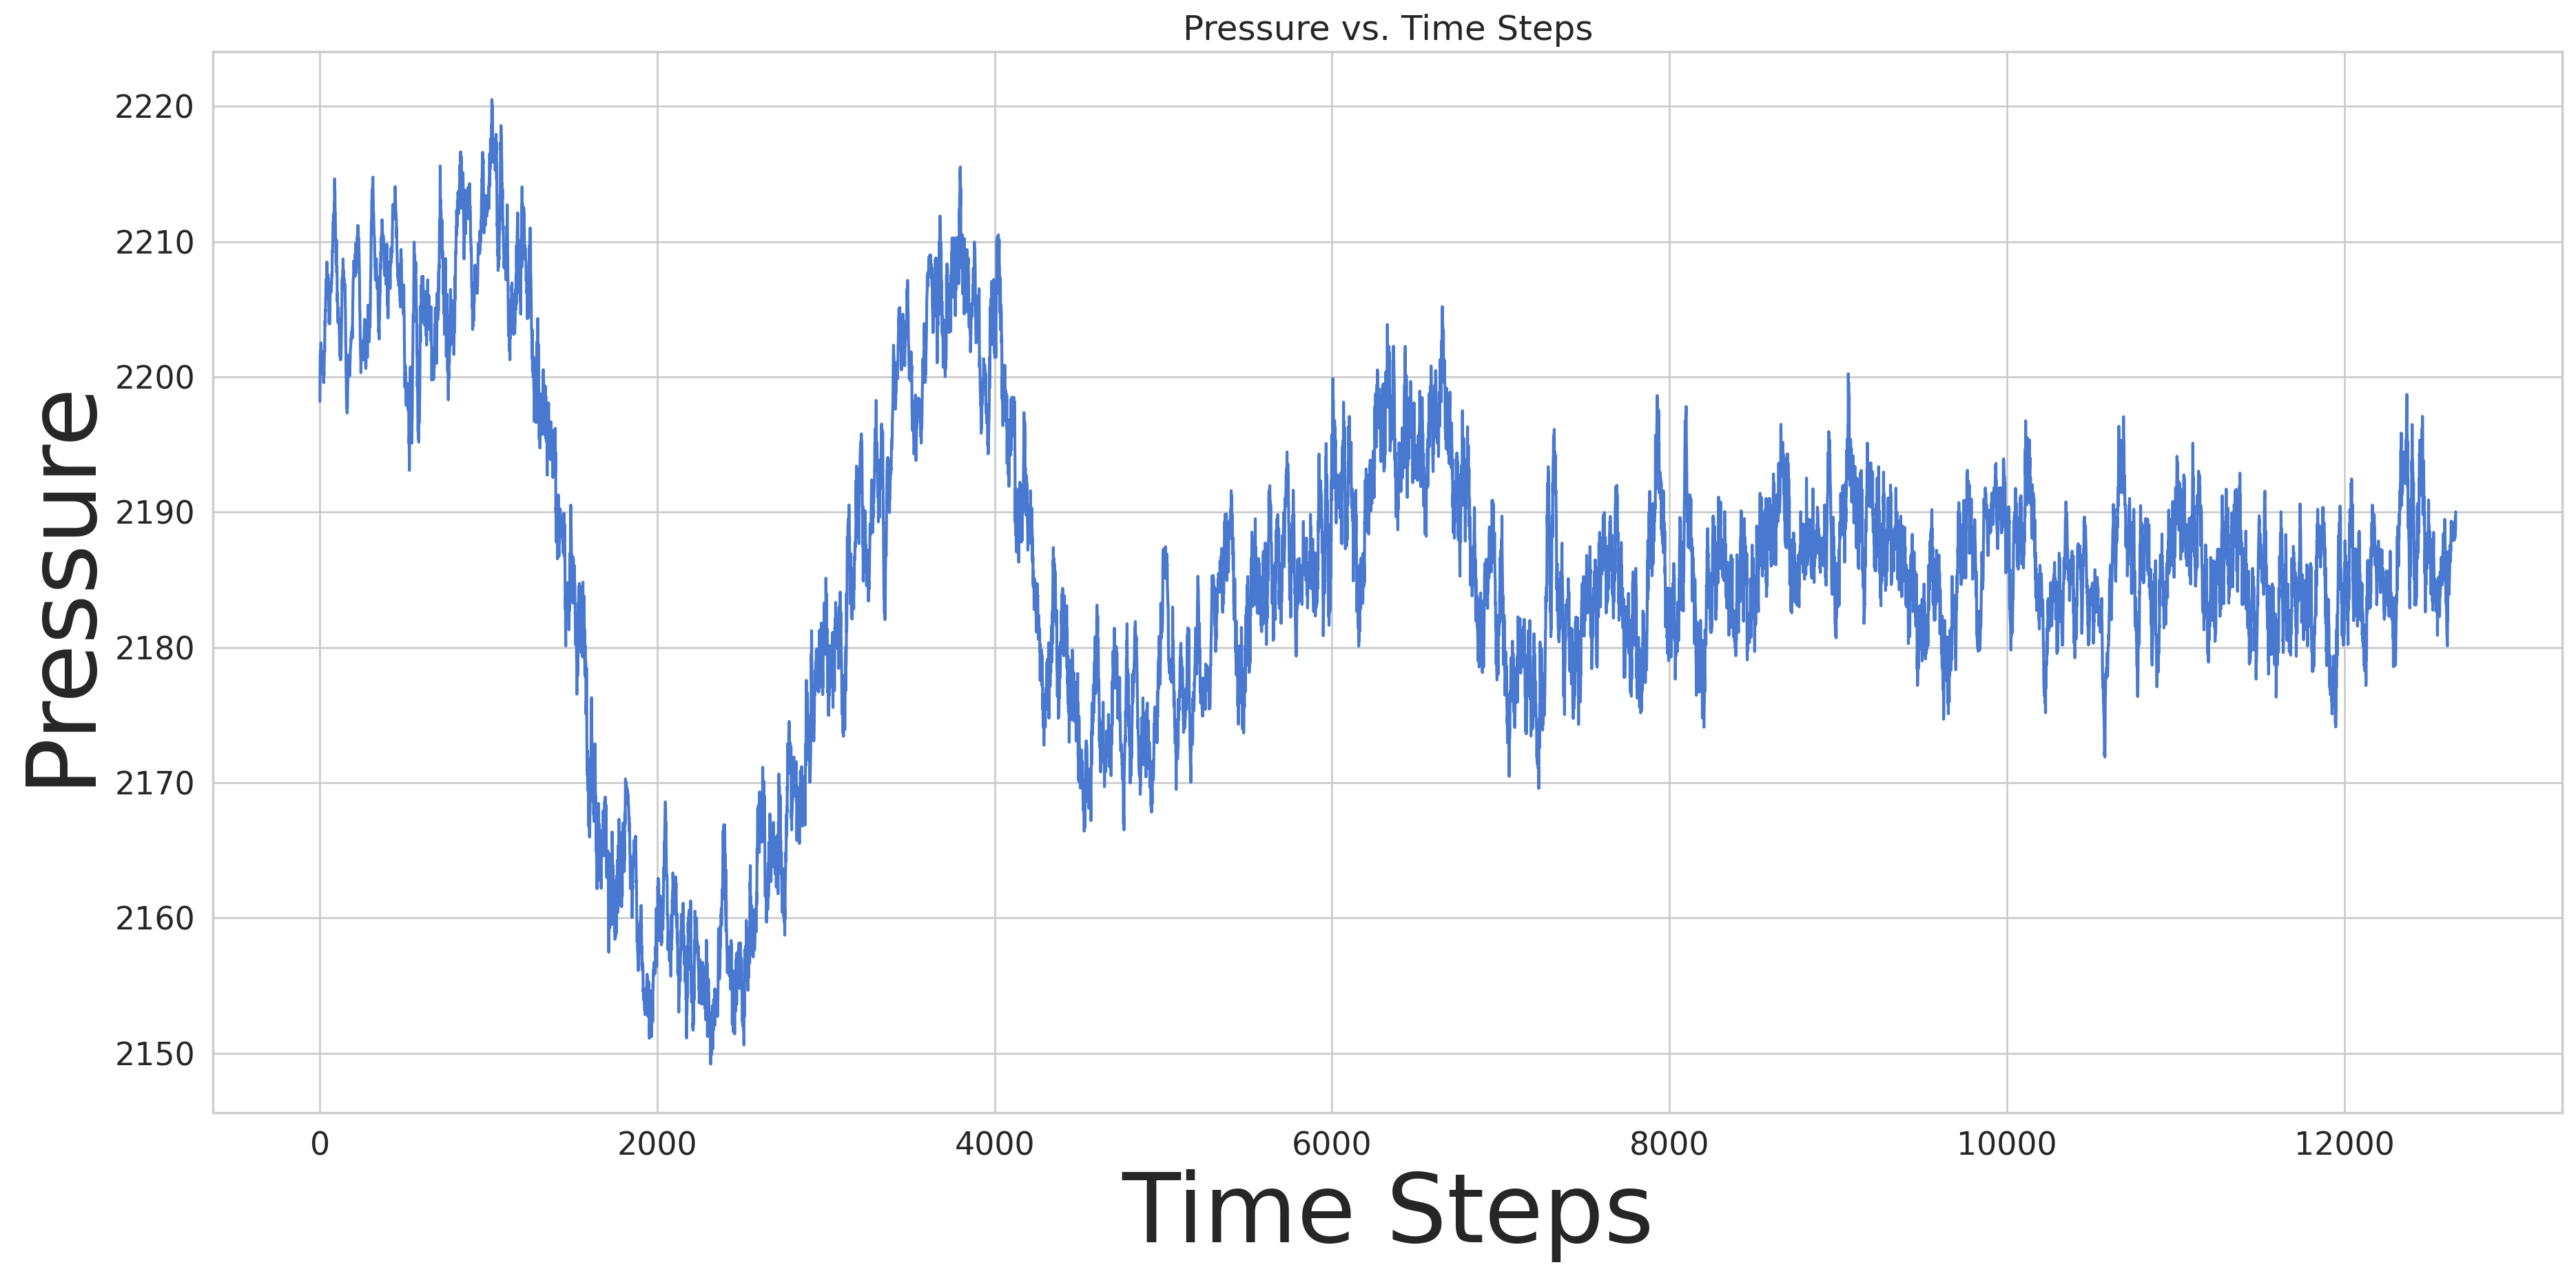

In [ ]:
!gdown --id 1PrxHkSQGBKoWJk4ec55gHC9-Mtj6s6ra --output spx.csv
# prompt: 读取spx.csv中的内容，然后绘图，横坐标是time steps，纵坐标是pressure

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('spx.csv')

plt.plot(df['time steps'], df['pressure'])
plt.title('Pressure vs. Time Steps')
plt.xlabel('Time Steps', fontsize=50)  # 设置横坐标标签的字体大小
plt.ylabel('Pressure', fontsize=50)
plt.show()

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/custom.csv')
df=data.copy()
df.head()
# prompt: 使用 DataFrame“df”: X轴是time steps，Y轴是pressure除以10后的值绘制一个图
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport pandas as pd\ndata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/custom.csv')\ndf=data.copy()\ndf.head()\n# prompt: 使用 DataFrame“df”: X轴是time steps，Y轴是pressure除以10后的值绘制一个图\n"

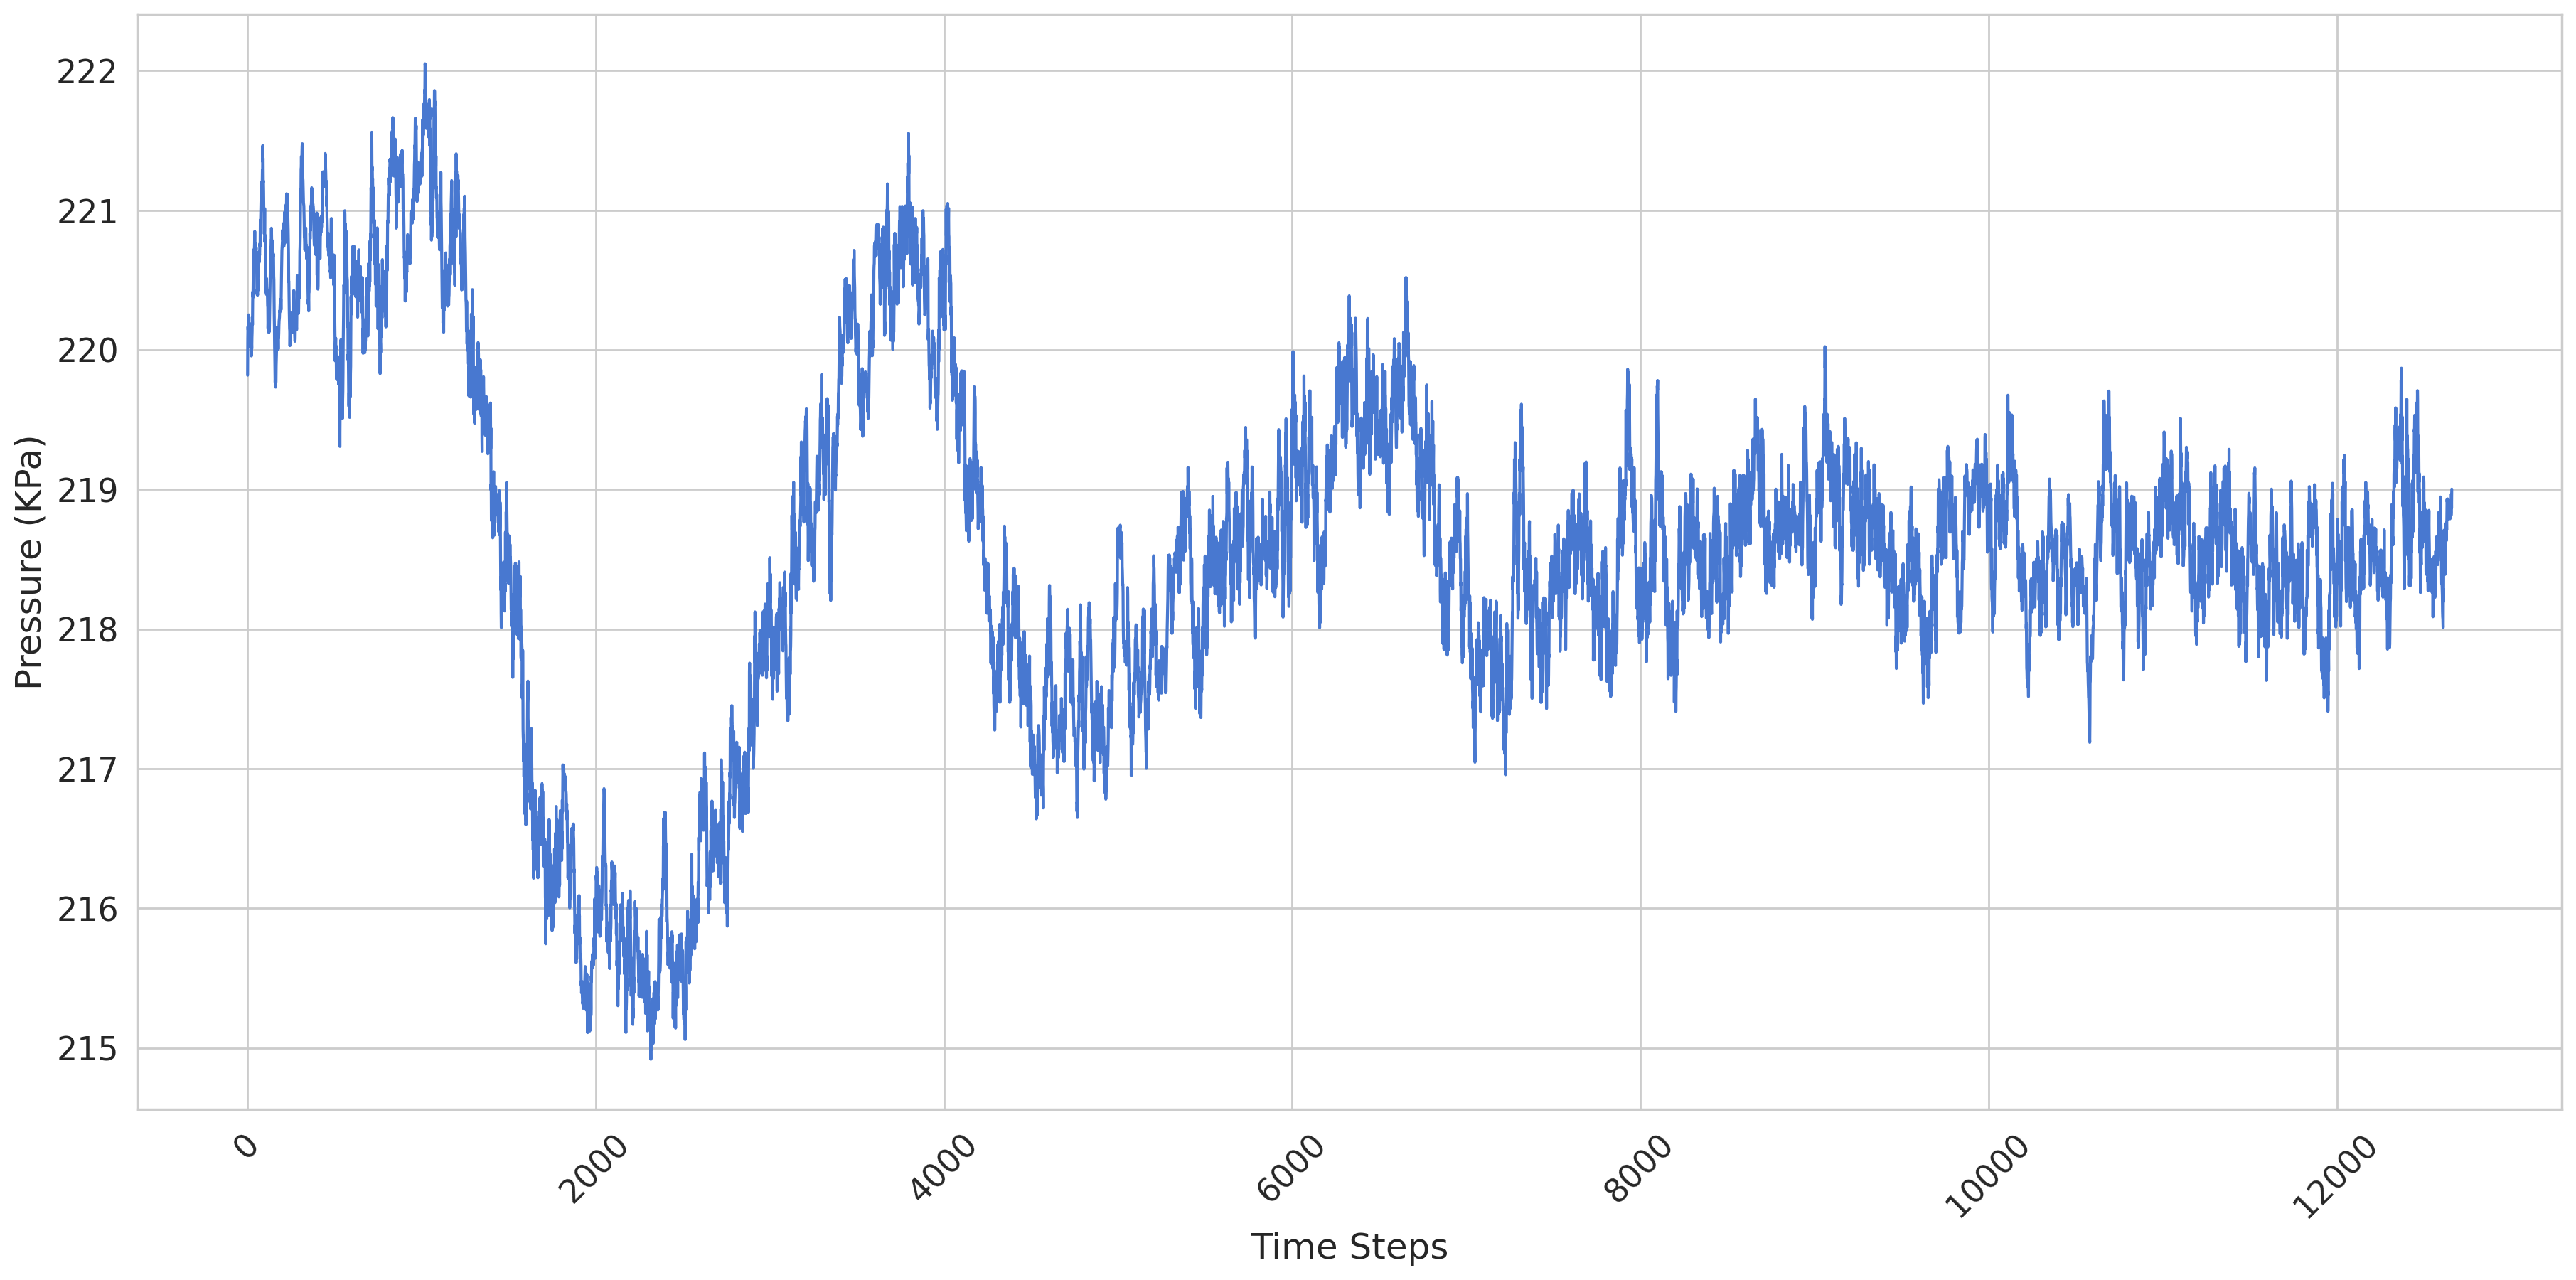

In [ ]:
import matplotlib.pyplot as plt

# 假设 df 是已加载的数据框
plt.plot(df["time steps"], df["pressure"]/10)

# 设置横纵坐标轴标签
plt.xlabel("Time Steps")
plt.ylabel("Pressure (KPa)")

# 控制刻度显示，设置横坐标刻度的位置和标签
plt.xticks(rotation=45)  # 如果刻度标签太长，可以旋转刻度标签

# 添加网格线
plt.grid(True)

# 显示图形
plt.show()


In [ ]:
#df.head()

In [ ]:
#plt.plot(df, label='pressure')
#plt.legend();

In [ ]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
all_size = len(df)
train, test ,all= df.iloc[0:train_size], df.iloc[train_size:len(df)],df.iloc[0:len(df)],
print(train.shape, test.shape, all.shape)

(12027, 2) (633, 2) (12660, 2)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['pressure']])
scaler = scaler.fit(all[['pressure']])

train['pressure'] = scaler.transform(train[['pressure']])
test['pressure'] = scaler.transform(test[['pressure']])
all['pressure'] = scaler.transform(all[['pressure']])

<ipython-input-42-21c5c4403de4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pressure'] = scaler.transform(train[['pressure']])
<ipython-input-42-21c5c4403de4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pressure'] = scaler.transform(test[['pressure']])


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['pressure']], train.pressure, TIME_STEPS)
X_test, y_test = create_dataset(test[['pressure']], test.pressure, TIME_STEPS)
X_all, y_all = create_dataset(all[['pressure']], all.pressure, TIME_STEPS)
print(X_train.shape,X_test.shape,X_all.shape)



(11997, 30, 1) (603, 30, 1) (12630, 30, 1)


In [ ]:
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, RepeatVector, TimeDistributed, LSTM # Import LSTM

# Define the encoder model with GRU
encoder_model = Sequential([
    Input(shape=X_train.shape[1:]),
    LSTM(100, return_sequences=False), # Now LSTM is defined
    Dense(30)
])

# Define the decoder model with GRU
decoder_model = Sequential([
    Input(shape=(30,)),
    RepeatVector(TIME_STEPS),
    LSTM(100, return_sequences=True), # Now LSTM is defined
    TimeDistributed(Dense(1))
])

# Define the autoencoder model
autoencoder_model = Sequential([
    encoder_model,
    decoder_model
])

# Compile the autoencoder model
autoencoder_model.compile(loss='mae', optimizer='adam')
model=autoencoder_model
'''

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Input, GRU, Dense, Dropout, RepeatVector, TimeDistributed, LSTM # Import LSTM\n\n# Define the encoder model with GRU\nencoder_model = Sequential([\n    Input(shape=X_train.shape[1:]),\n    LSTM(100, return_sequences=False), # Now LSTM is defined\n    Dense(30)\n])\n\n# Define the decoder model with GRU\ndecoder_model = Sequential([\n    Input(shape=(30,)),\n    RepeatVector(TIME_STEPS),\n    LSTM(100, return_sequences=True), # Now LSTM is defined\n    TimeDistributed(Dense(1))\n])\n\n# Define the autoencoder model\nautoencoder_model = Sequential([\n    encoder_model,\n    decoder_model\n])\n\n# Compile the autoencoder model\nautoencoder_model.compile(loss='mae', optimizer='adam')\nmodel=autoencoder_model\n"

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    LayerNormalization,
    MultiHeadAttention,
    GlobalAveragePooling1D,
    RepeatVector,
    TimeDistributed,
    Add,
)
from tensorflow.keras.optimizers import Adam
import numpy as np

# 假设 X_train 已经定义，形状为 (num_samples, TIME_STEPS, feature_dim)
# 例如：
# X_train = np.random.rand(1000, 10, 1)

# 示例数据（请使用实际数据替换）
# X_train = ...

# 位置编码函数
def get_positional_encoding(maxlen, d_model):
    pos = np.arange(maxlen)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # 应用sin到偶数索引，cos到奇数索引
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer编码器块
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 层归一化和多头自注意力
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # 前馈神经网络
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# 构建编码器
def build_transformer_encoder(
    input_shape,
    latent_dim,
    num_transformer_blocks,
    head_size,
    num_heads,
    ff_dim,
    dropout=0.1,
):
    inputs = Input(shape=input_shape)
    x = inputs

    # 添加位置编码
    maxlen = input_shape[0]
    d_model = input_shape[1]
    pos_encoding = get_positional_encoding(maxlen, d_model)
    x = Add()([x, pos_encoding[:, :maxlen, :]])

    # 添加多个Transformer编码器块
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # 全局平均池化得到固定长度的潜在表示
    x = GlobalAveragePooling1D()(x)
    x = Dense(latent_dim, activation="relu")(x)
    encoder = Model(inputs, x, name="encoder")
    return encoder

# 构建解码器
def build_transformer_decoder(
    latent_dim,
    time_steps,
    feature_dim,
    num_transformer_blocks,
    head_size,
    num_heads,
    ff_dim,
    dropout=0.1,
):
    inputs = Input(shape=(latent_dim,))
    x = RepeatVector(time_steps)(inputs)

    # 添加位置编码
    d_model = feature_dim
    pos_encoding = get_positional_encoding(time_steps, d_model)
    x = Add()([x, pos_encoding[:, :time_steps, :]])

    # 添加多个Transformer编码器块
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = TimeDistributed(Dense(ff_dim, activation="relu"))(x)
    outputs = TimeDistributed(Dense(feature_dim))(x)
    decoder = Model(inputs, outputs, name="decoder")
    return decoder

# 获取输入形状
input_shape = X_train.shape[1:]  # (TIME_STEPS, feature_dim)
time_steps = input_shape[0]
feature_dim = input_shape[1]
latent_dim = 30

# Transformer超参数
num_transformer_blocks = 3
head_size = 64
num_heads = 4
ff_dim = 128
dropout = 0.1

# 构建编码器和解码器
encoder = build_transformer_encoder(
    input_shape,
    latent_dim,
    num_transformer_blocks,
    head_size,
    num_heads,
    ff_dim,
    dropout,
)

decoder = build_transformer_decoder(
    latent_dim,
    time_steps,
    feature_dim,
    num_transformer_blocks,
    head_size,
    num_heads,
    ff_dim,
    dropout,
)

# 构建Autoencoder模型
autoencoder_input = Input(shape=input_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded, name="autoencoder")

# 编译模型
autoencoder.compile(optimizer=Adam(), loss="mae")
model=autoencoder
# 模型摘要（可选）
'autoencoder.summary()'

# 现在，模型已经准备好进行训练
# 例如：
# autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)


'autoencoder.summary()'

In [ ]:
import tensorflow as tf

# Build the model by specifying the input shape
model.build((None, X_train.shape[1], X_train.shape[2]))

total_params = model.count_params()
print(f"Total parameters: {total_params}")

Total parameters: 129131


In [ ]:
'''
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    shuffle=False
)
'''

'\nhistory = model.fit(\n    X_train, y_train,\n    epochs=10,\n    batch_size=128,\n    validation_split=0.1,\n    shuffle=False\n)\n'

In [ ]:
# prompt: 计算训练所用的时间

import time

start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    shuffle=False
)

end_time = time.time()

training_time = end_time - start_time

print(f"Training time: {training_time:.4f} seconds")


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 73s 403ms/step - loss: 0.7468 - val_loss: 0.2376
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9128 - val_loss: 0.2380
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1216 - val_loss: 0.2357
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.9651 - val_loss: 0.2401
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.1541 - val_loss: 0.2468
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7336 - val_loss: 0.2428
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9549 - val_loss: 0.2257
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9295 - val_loss: 0.2285
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7717 - val_loss: 0.2468
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9695 - val_loss: 0.2345
Training time: 90.3839 seconds


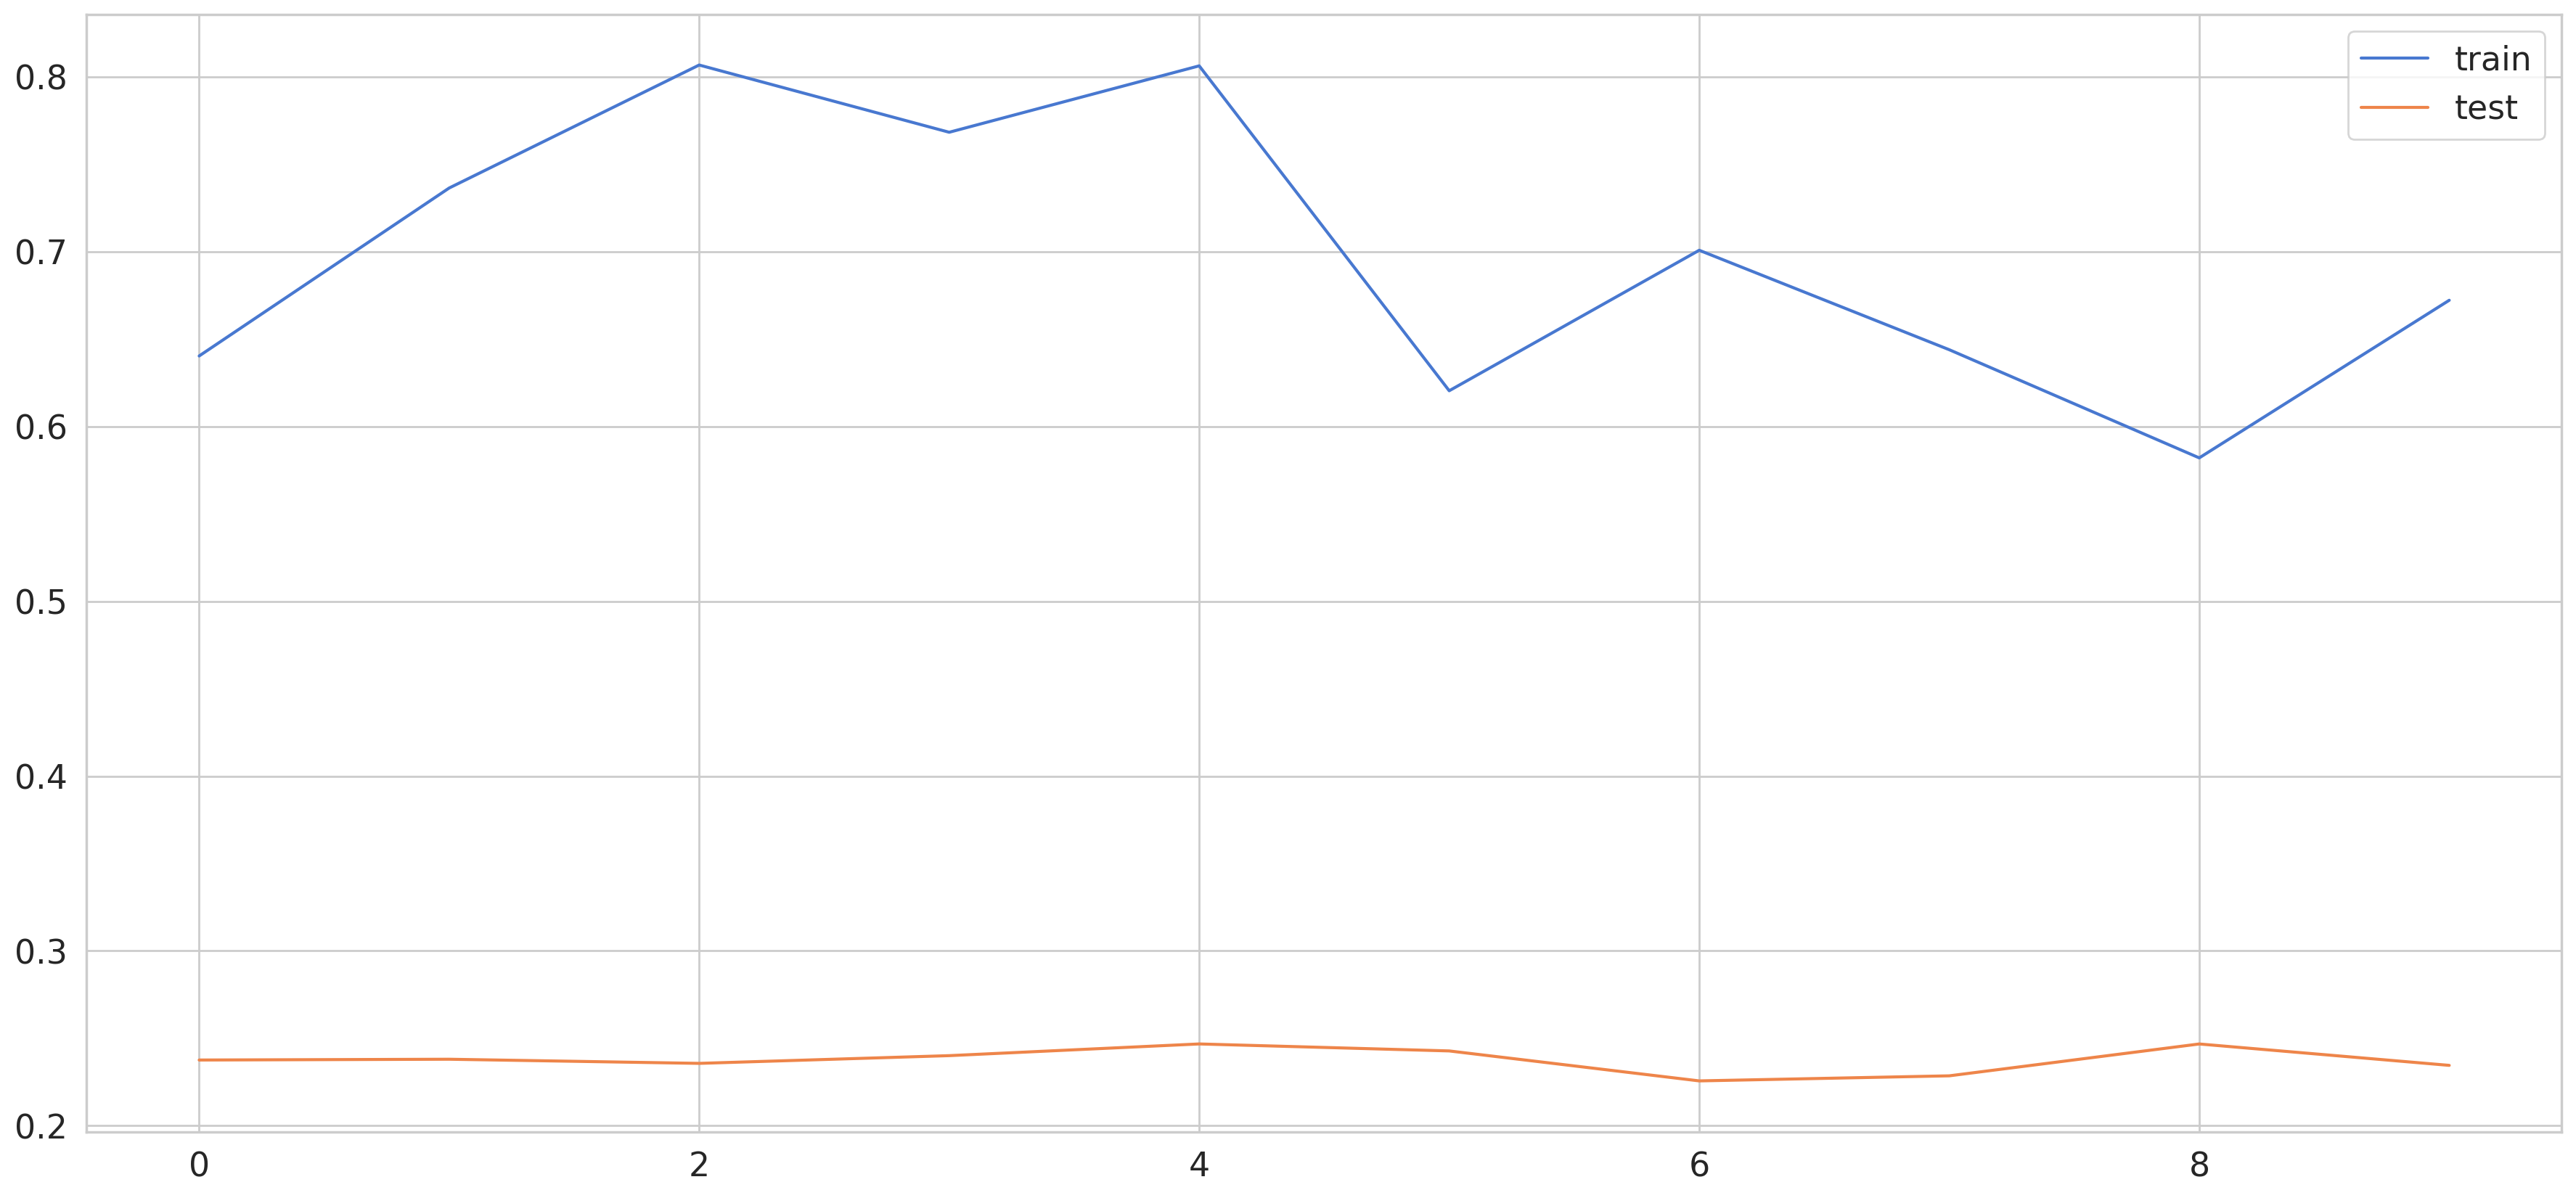

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


<ipython-input-52-799f7bf2afcd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


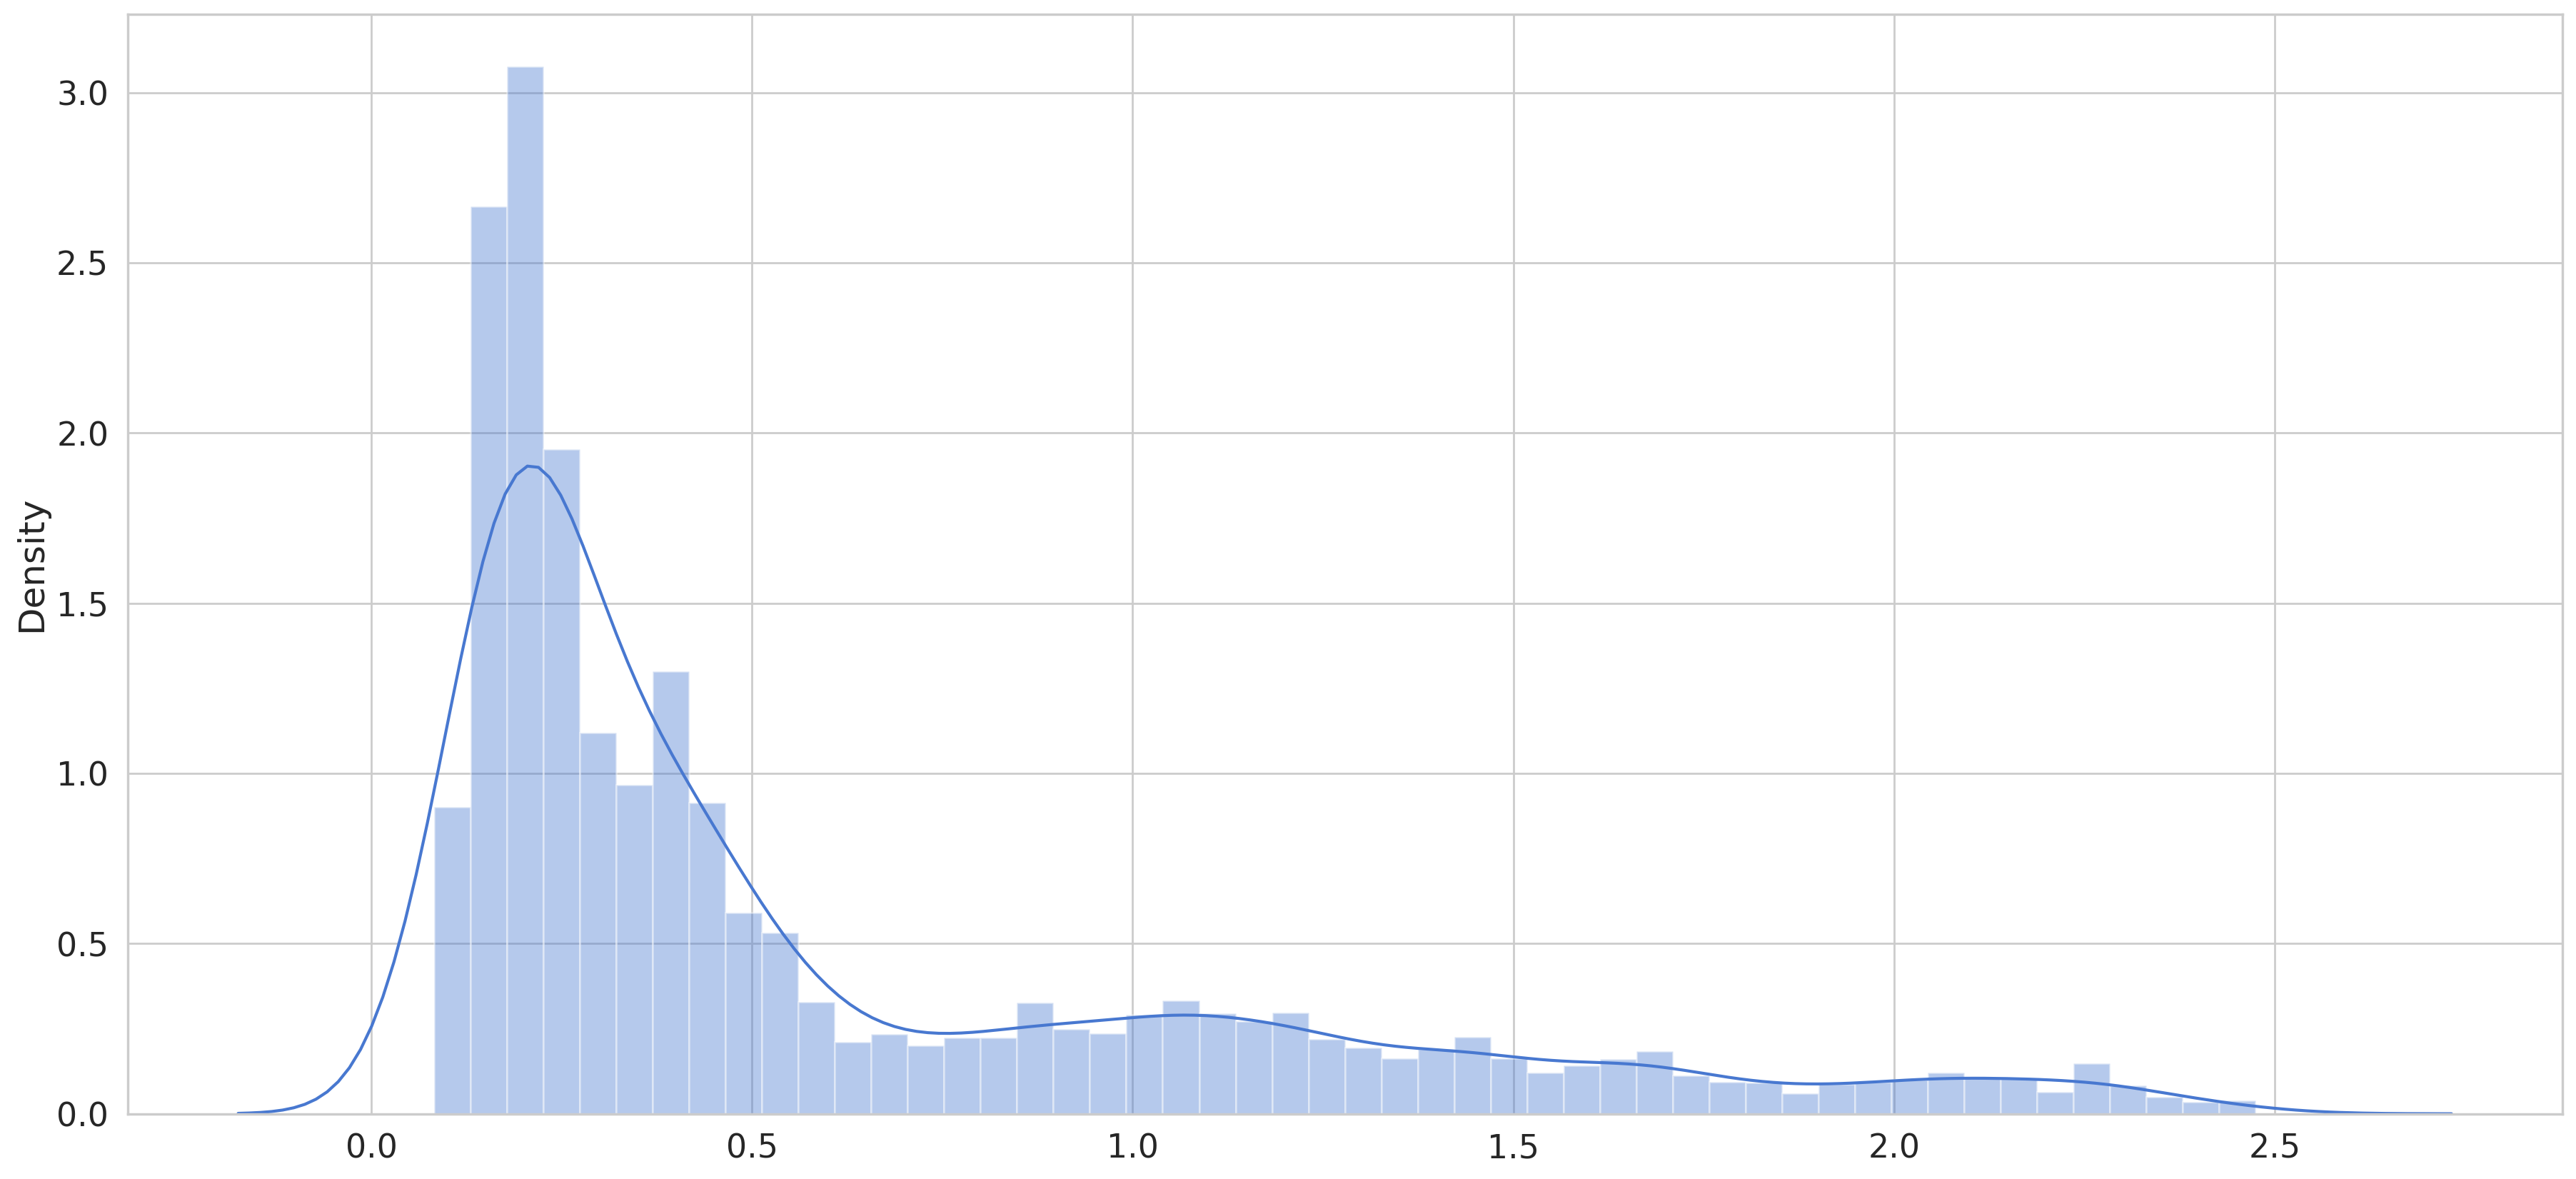

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step


In [ ]:
X_all_pred = model.predict(X_all)

all_mae_loss = np.mean(np.abs(X_all_pred - X_all), axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [ ]:
THRESHOLD =1.1

all_score_df = pd.DataFrame(index=all[TIME_STEPS:].index)
all_score_df['loss'] = all_mae_loss
all_score_df['threshold'] = THRESHOLD
all_score_df['anomaly'] = all_score_df.loss > all_score_df.threshold
all_score_df['pressure'] = all[TIME_STEPS:].pressure

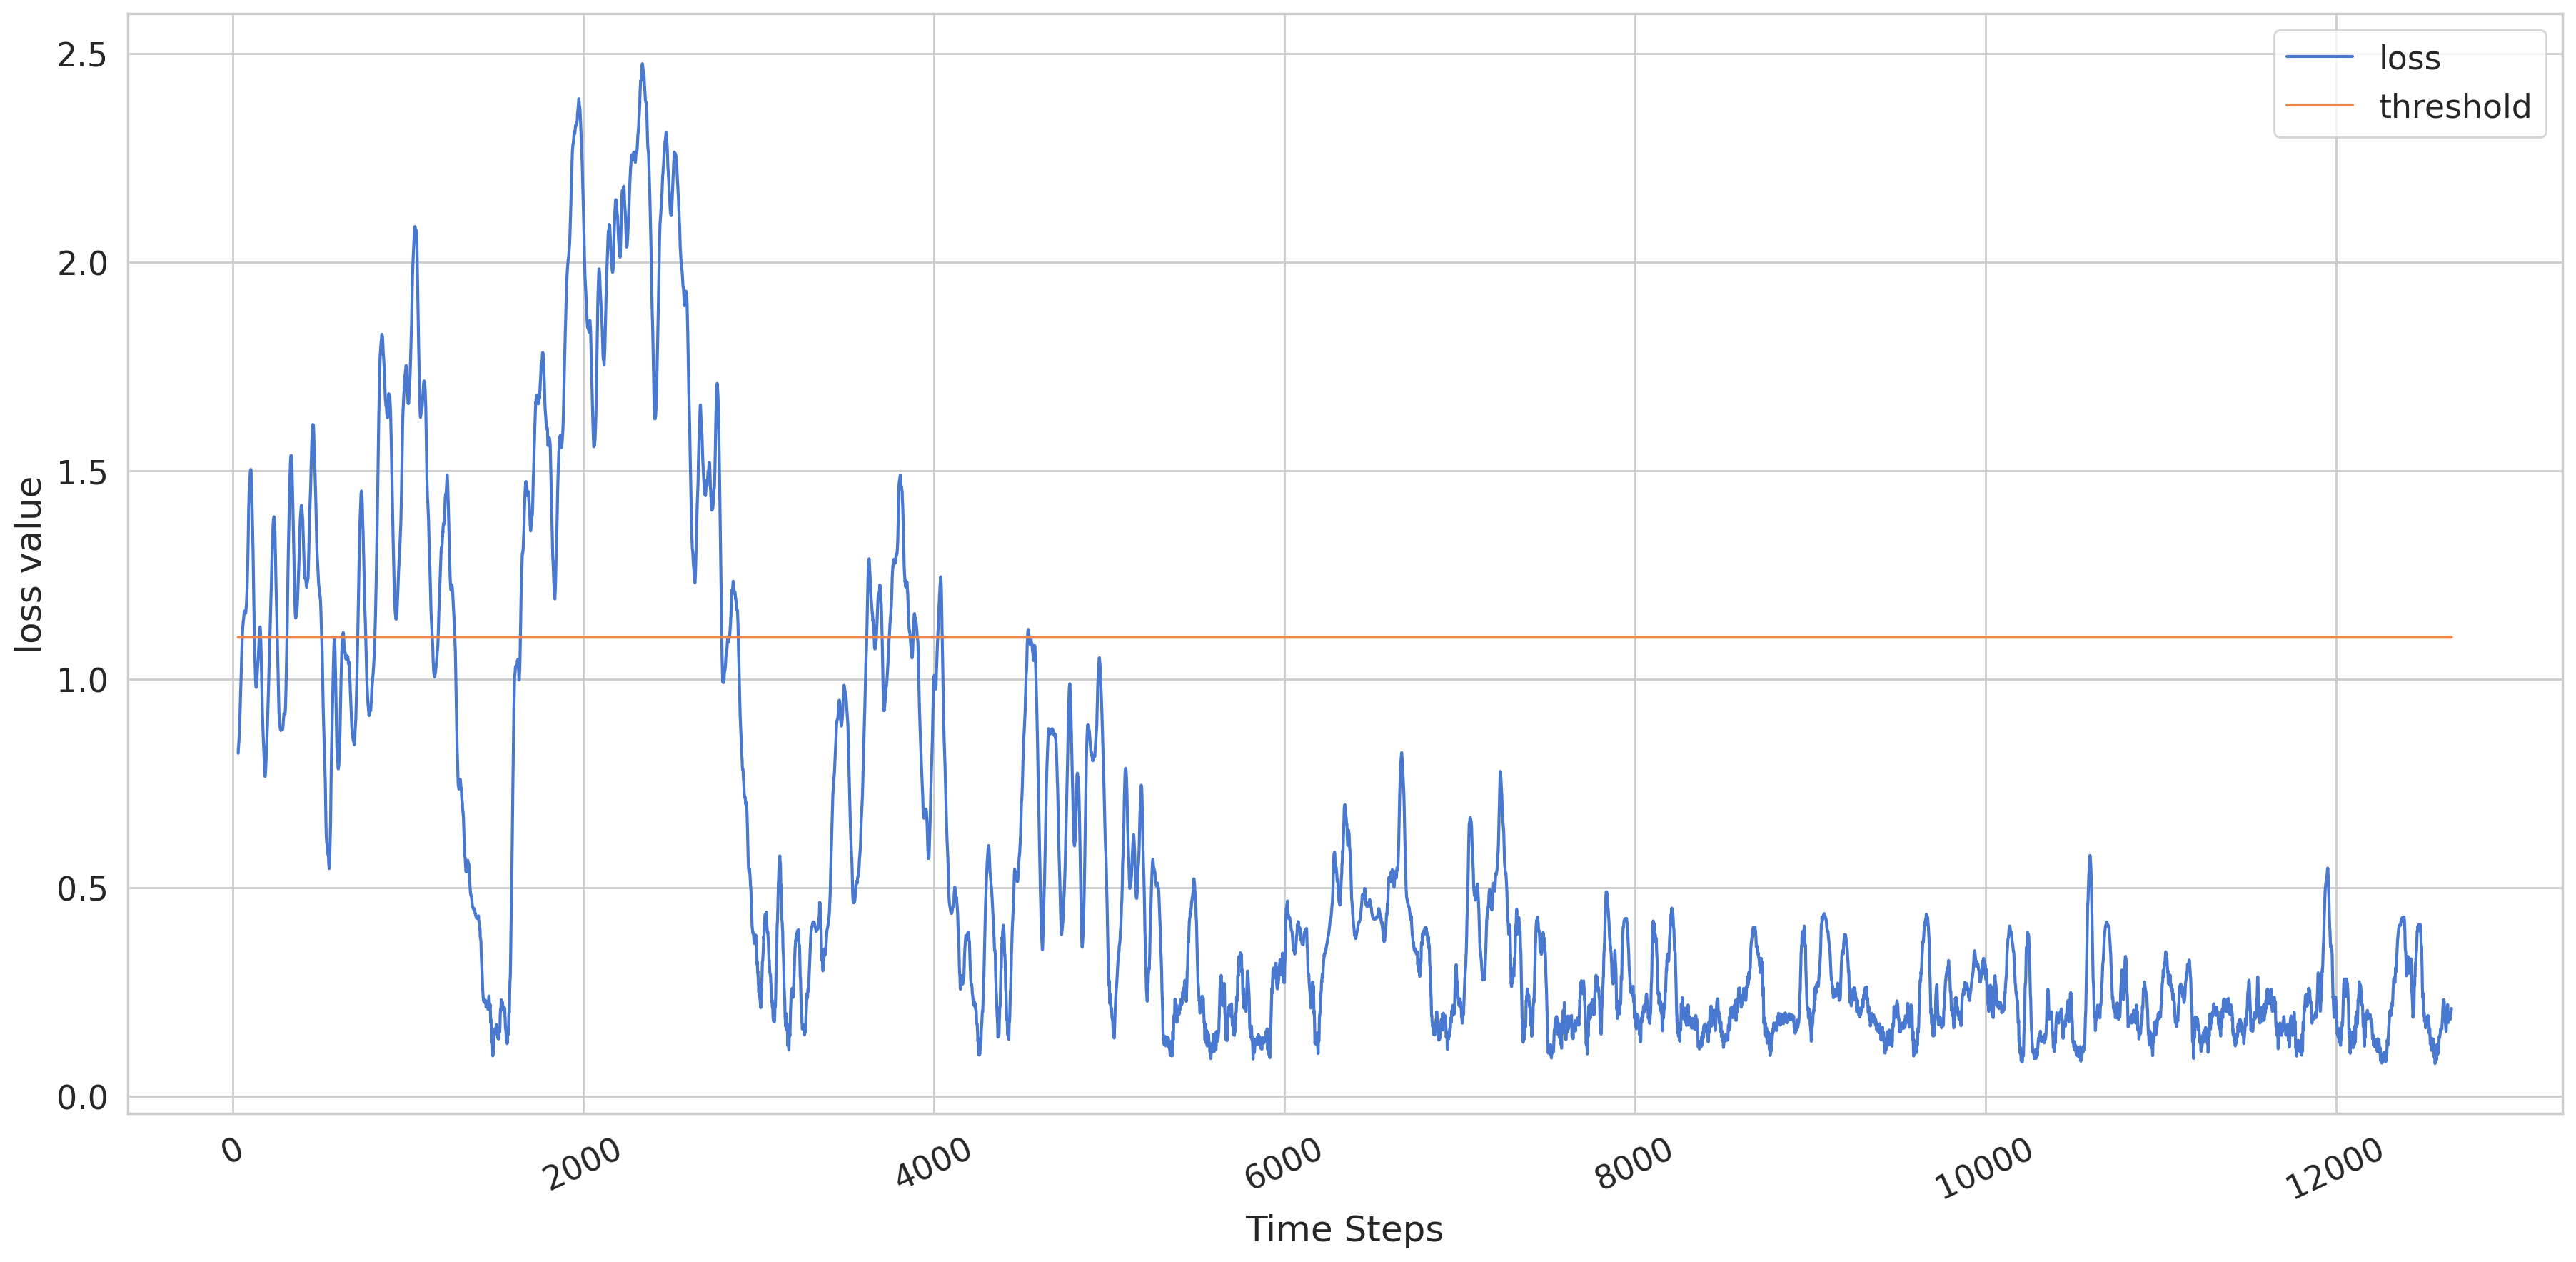

In [ ]:
plt.plot(all_score_df.index, all_score_df.loss, label='loss')
plt.plot(all_score_df.index, all_score_df.threshold, label='threshold')
plt.xlabel("Time Steps")
plt.ylabel("loss value")
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies = all_score_df[all_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,pressure
54,1.104690,1.1,True,1.432295
55,1.113432,1.1,True,1.458780
56,1.121344,1.1,True,1.449026
57,1.128008,1.1,True,1.428172
58,1.131590,1.1,True,1.511987


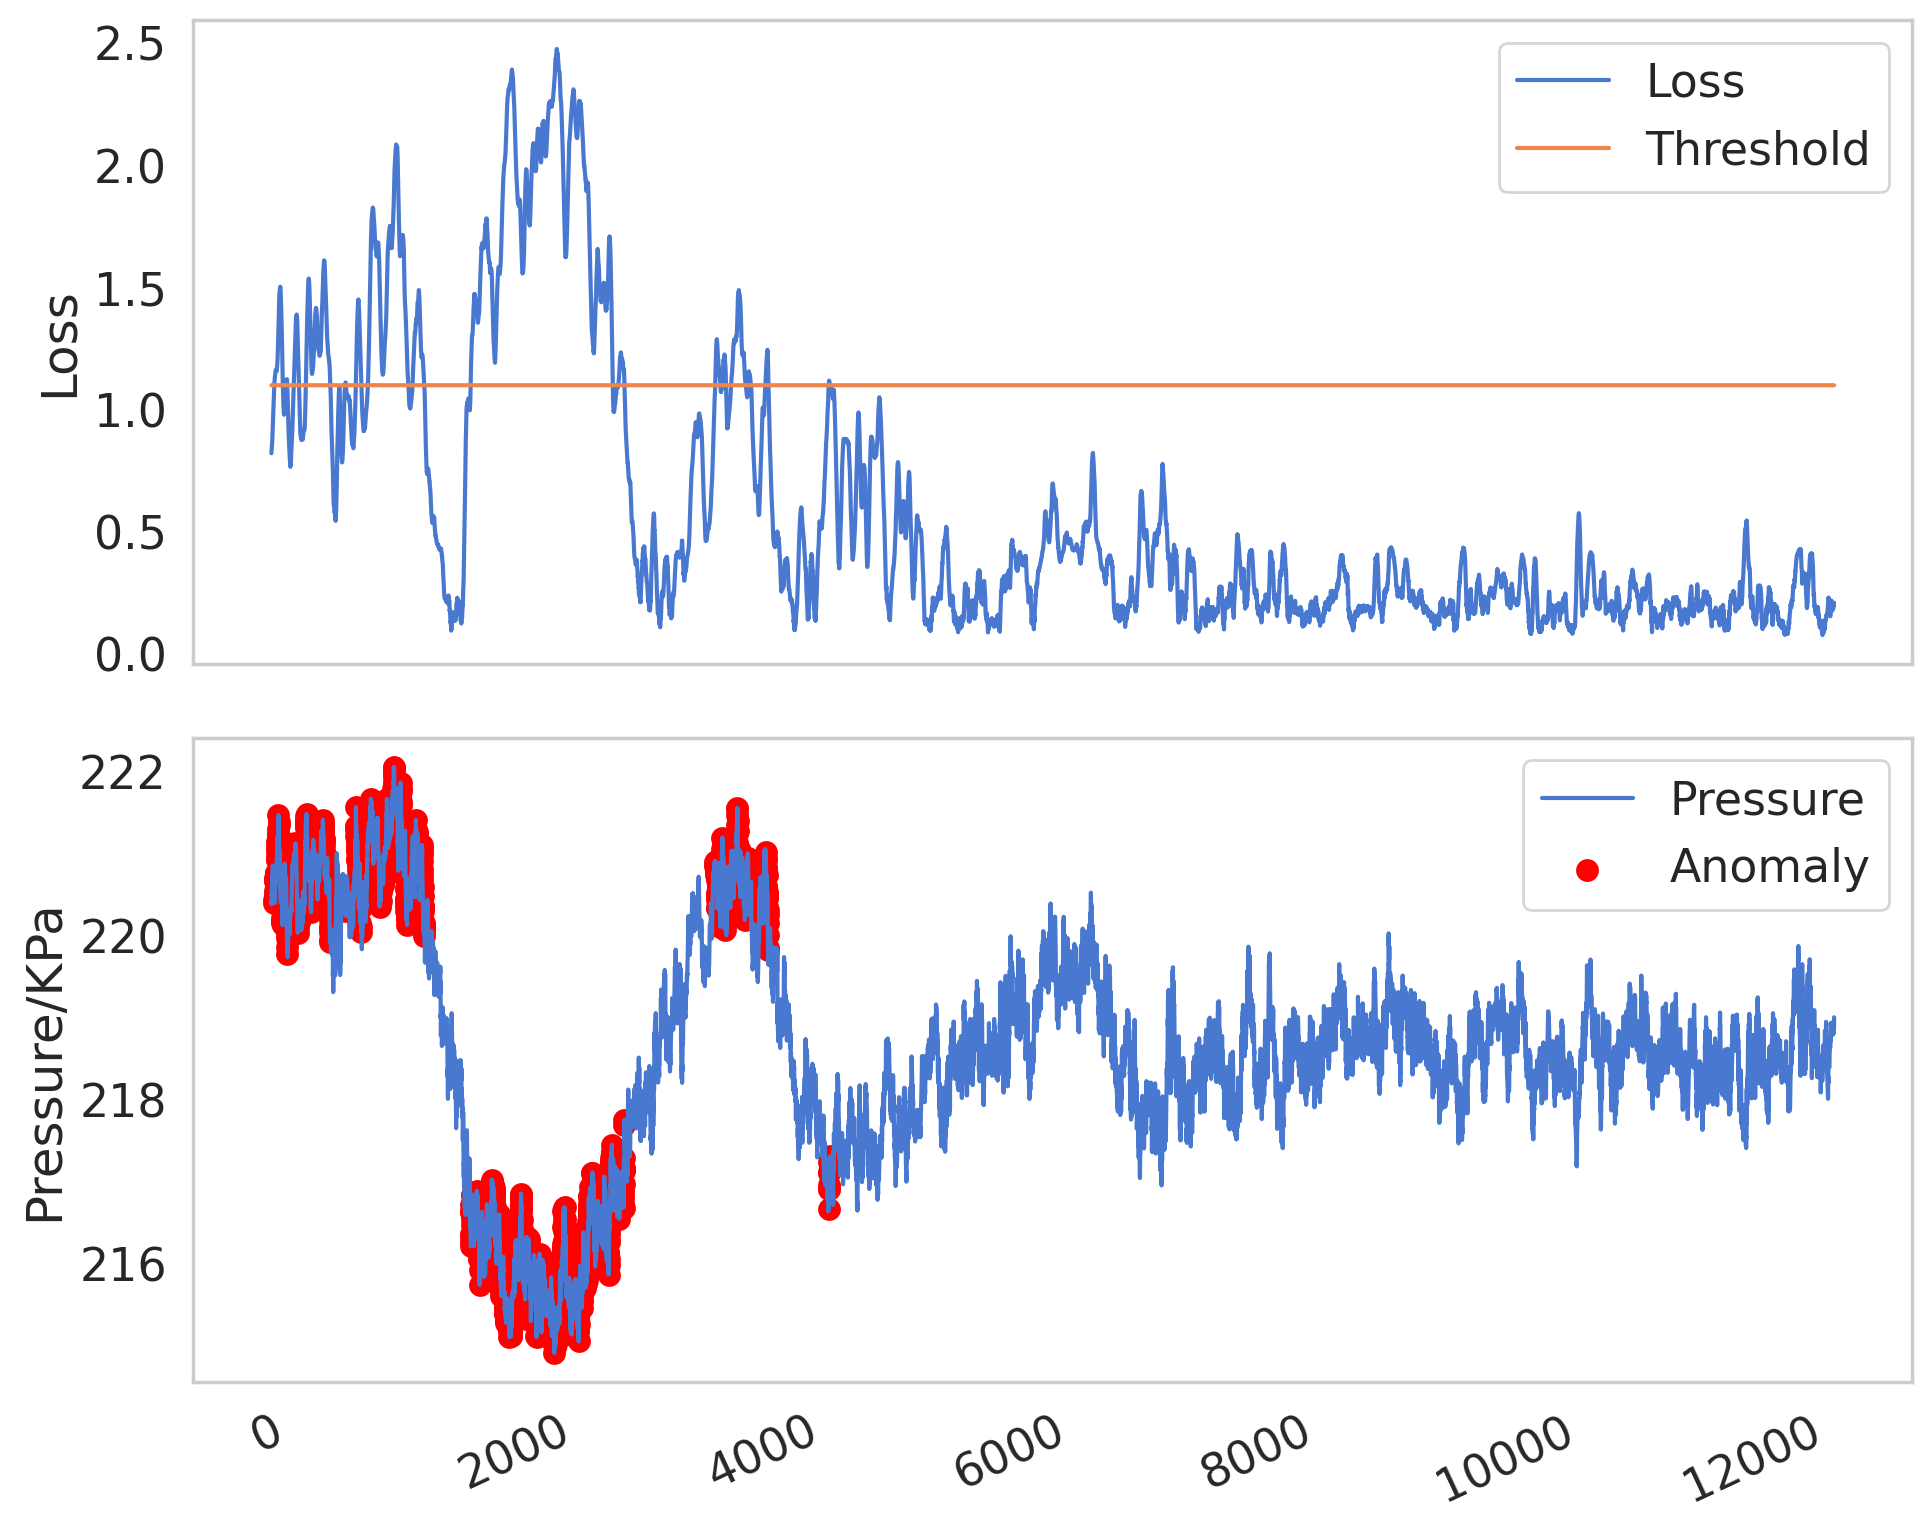

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你已经定义了变量 'test', 'anomalies', 和 'scaler'

# 重塑数据前修改这部分
pressure_prices_all = scaler.inverse_transform(all[TIME_STEPS:].pressure.values.reshape(1, -1)).reshape(-1) / 10
pressure_prices_anomalies = scaler.inverse_transform(anomalies.pressure.values.reshape(1, -1)).reshape(-1) / 10

# 创建图形和坐标轴
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
#ax1.set_title('GRU-AE Example Demonstration of Traditional Reconstruction Error Anomaly Detection Based on Threshold', fontsize=14)

# 第一个图：压力价格与异常值, 使用 matplotlib 的 scatter 方法
ax2.plot(
  all[TIME_STEPS:].index,
  pressure_prices_all,
  label='Pressure'
)
ax2.scatter(
  anomalies.index,
  pressure_prices_anomalies,
  color='red',  # 使用红色标记异常点
  s=52,         # 设置点的大小
  label='Anomaly'
)
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels([int(x) for x in ax2.get_xticks()], rotation=25)
ax2.legend()
ax2.set_ylabel('Pressure/KPa')

# 第二个图：损失和阈值随时间变化
ax1.plot(
  all_score_df.index,
  all_score_df.loss,
  label='Loss'
)
ax1.plot(
  all_score_df.index,
  all_score_df.threshold,
  label='Threshold'
)
ax1.set_xticklabels([int(x) for x in ax1.get_xticks()], rotation=25)
ax1.legend()
ax1.set_ylabel('Loss')
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()  # 调整布局以防重叠
plt.show()


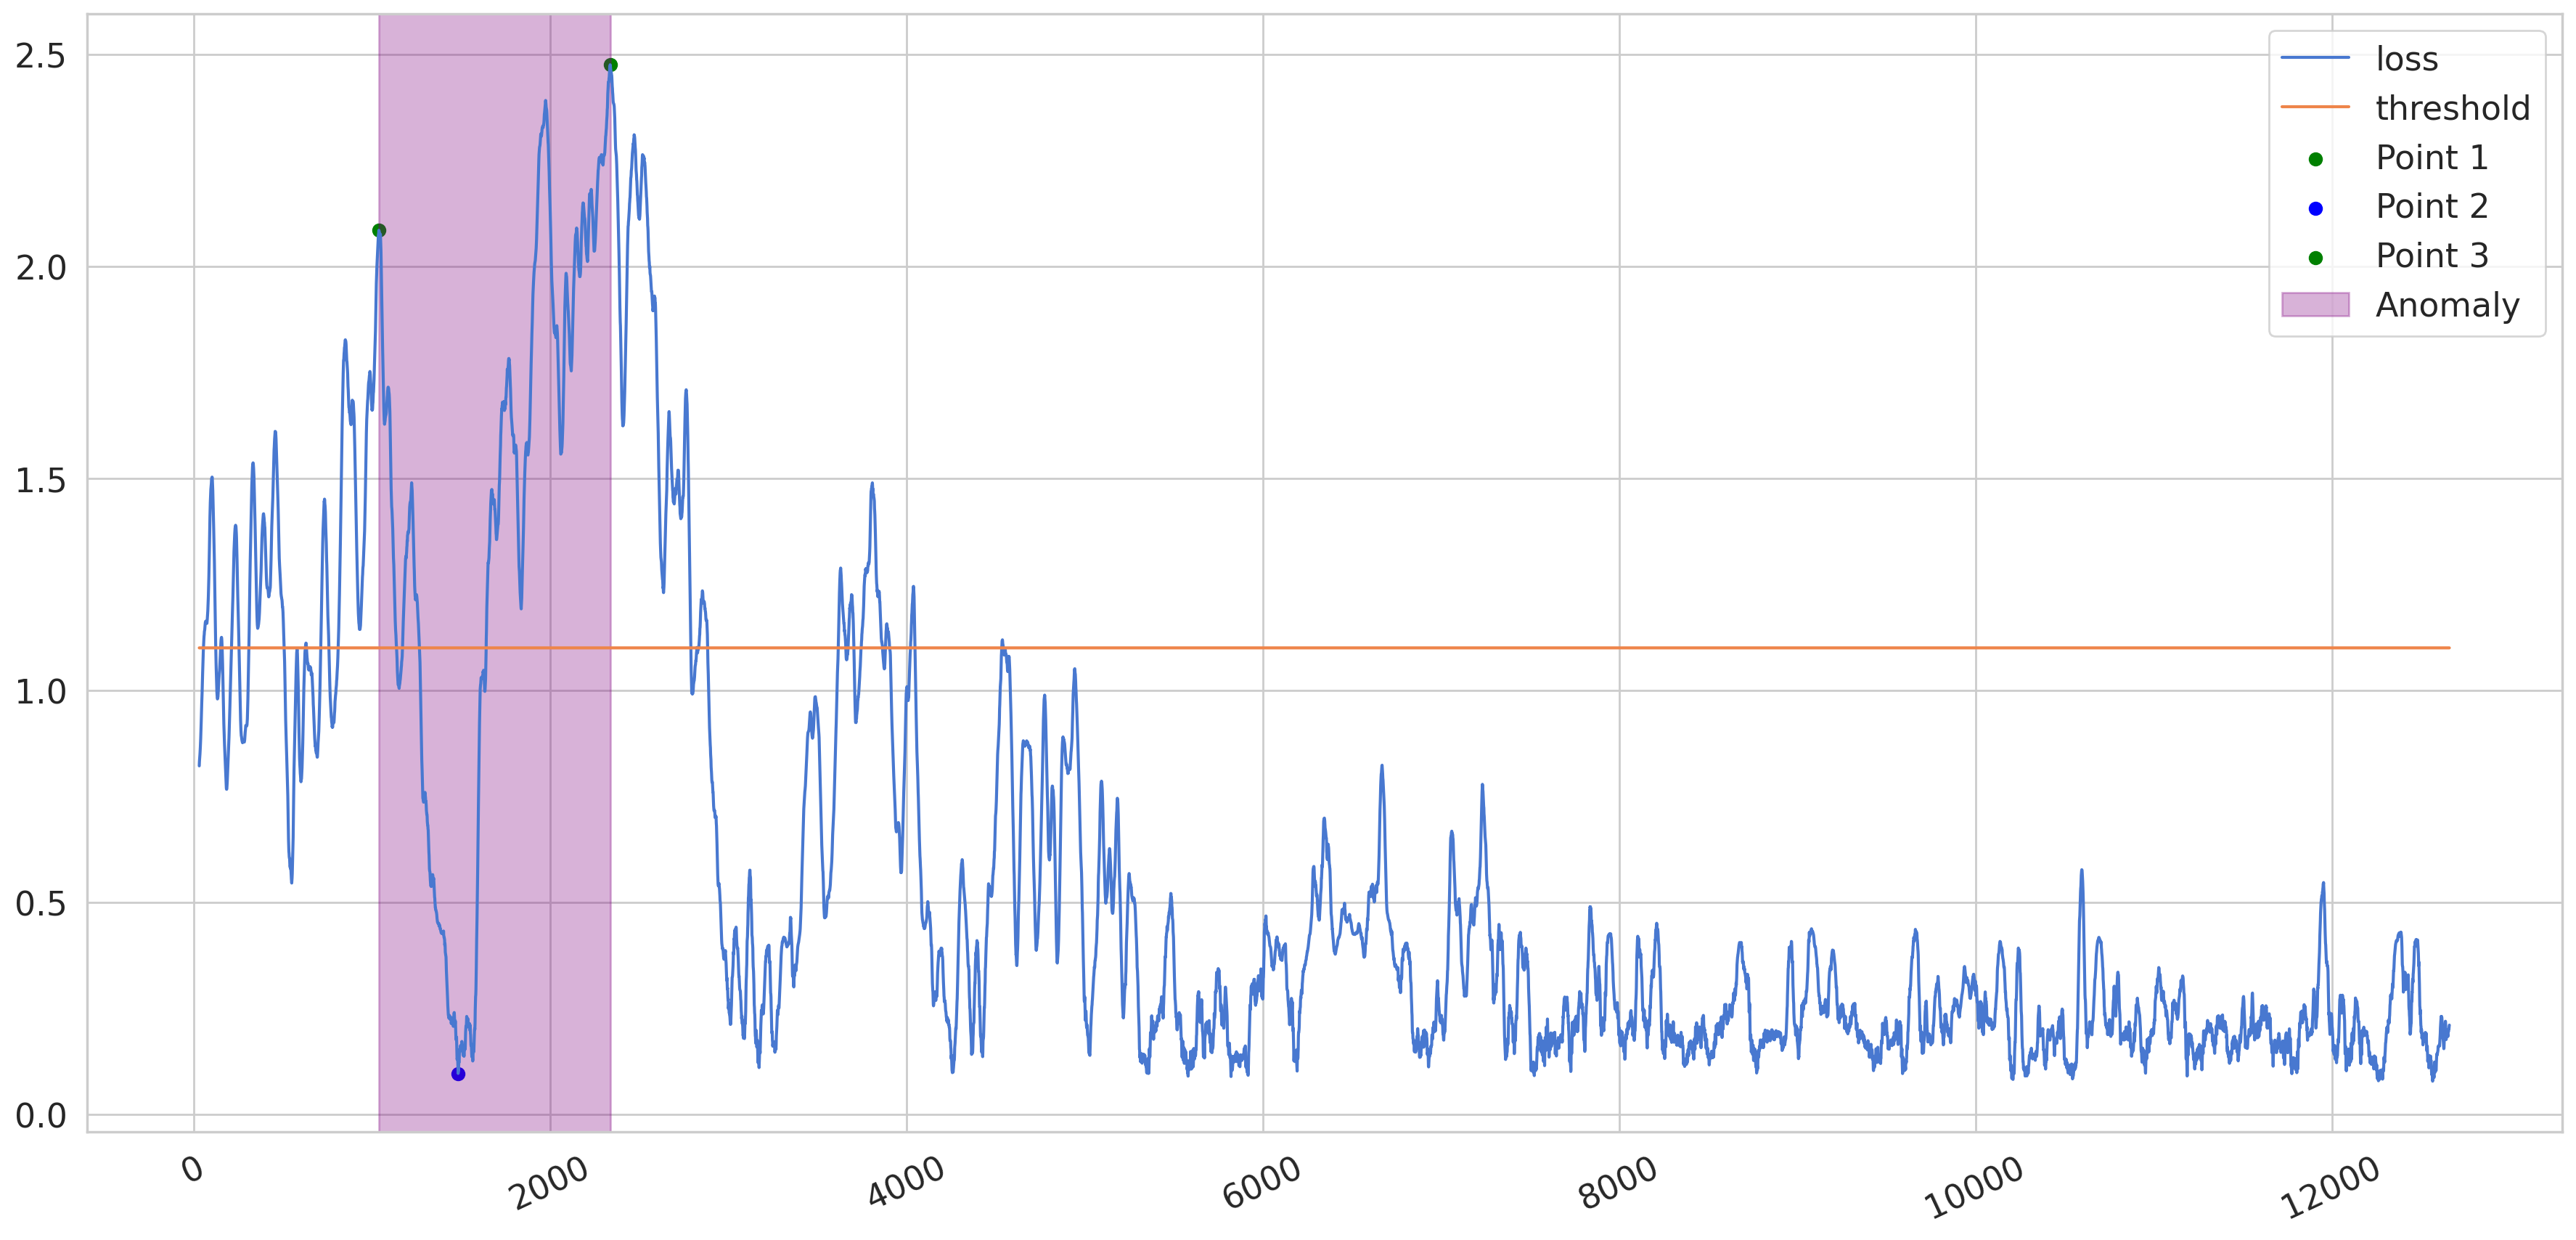

In [ ]:

import matplotlib.pyplot as plt
# Find the index of the point with the maximum loss
max_loss_index = all_score_df['loss'].idxmax()

# Find the index of the point with the minimum loss before the maximum loss point
min_loss_index_before_max = all_score_df.loc[:max_loss_index]['loss'].idxmin()

# Find the index of the point with the maximum loss **before** the minimum loss point
# Search from the beginning of the DataFrame up to Point 2
max_loss_index_before_min = all_score_df.loc[:min_loss_index_before_max]['loss'].idxmax()

# Plot the points
plt.plot(all_score_df.index, all_score_df.loss, label='loss')
plt.plot(all_score_df.index, all_score_df.threshold, label='threshold')
plt.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'loss'], color='green', label='Point 1')
plt.scatter(min_loss_index_before_max, all_score_df.loc[min_loss_index_before_max, 'loss'], color='blue', label='Point 2')
plt.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'loss'], color='green', label='Point 3')

# Plot the points between point 1 and point 3
plt.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')

plt.xticks(rotation=25)
plt.legend();


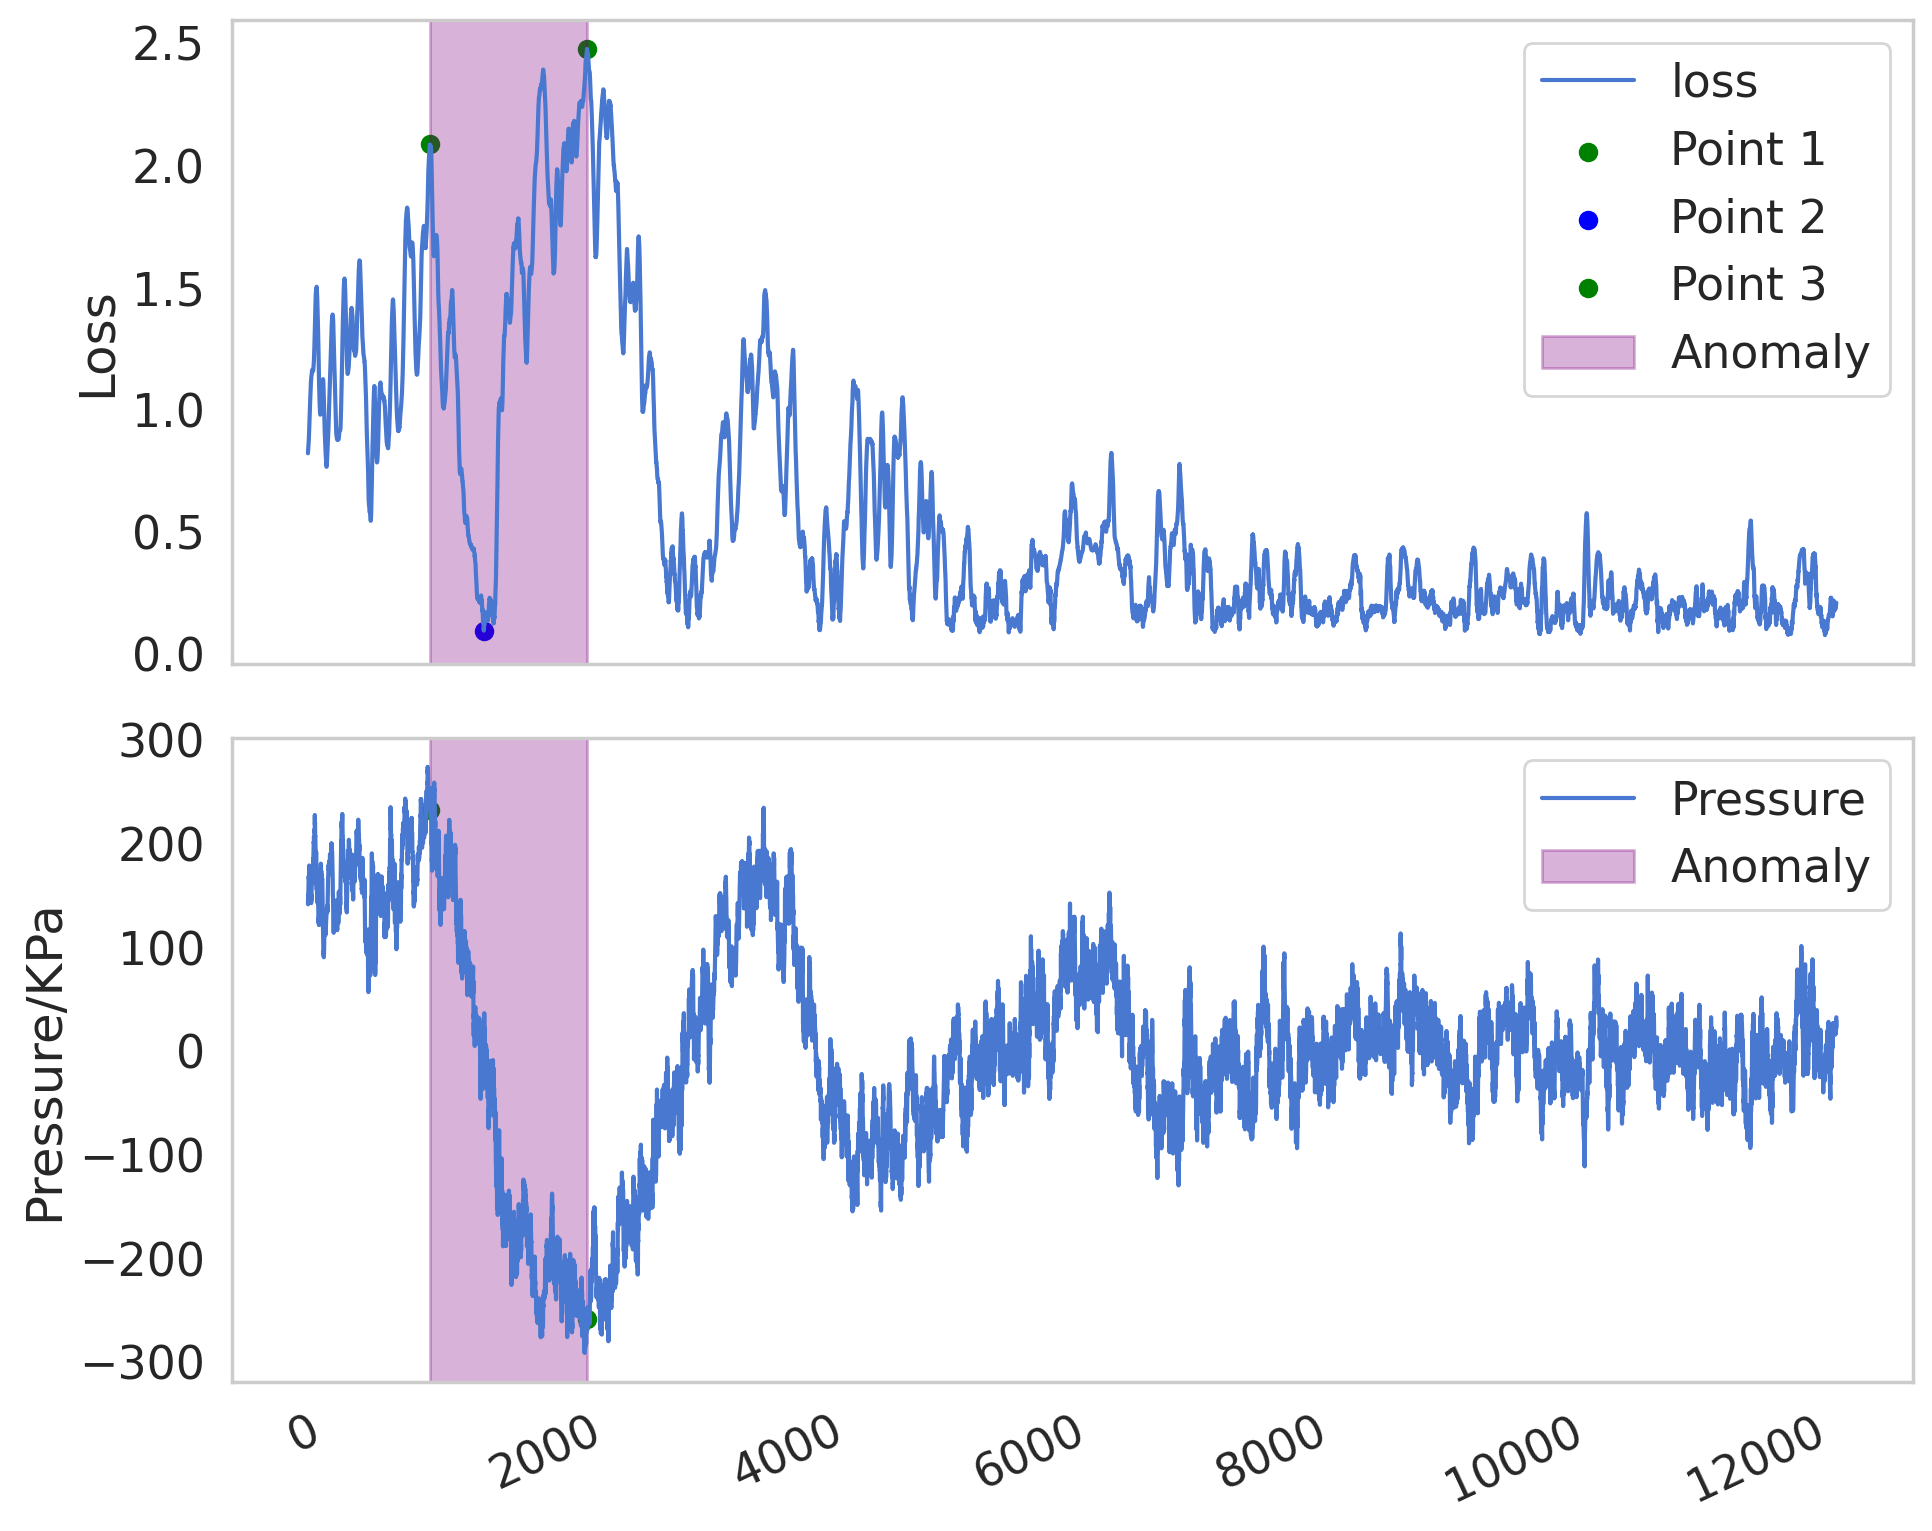

In [ ]:
import matplotlib.pyplot as plt

# Assuming previous code to calculate indices remains the same

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
#ax1.set_title('GRU-AE Example Demonstration', fontsize=14)
# Plot loss and threshold on the first axis
ax1.plot(all_score_df.index, all_score_df.loss, label='loss')
ax1.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'loss'], color='green', label='Point 1')
ax1.scatter(min_loss_index_before_max, all_score_df.loc[min_loss_index_before_max, 'loss'], color='blue', label='Point 2')
ax1.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'loss'], color='green', label='Point 3')
ax1.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(False)

# Plot pressure on the second axis with adjusted Y axis
ax2.plot(all_score_df.index, all_score_df.pressure * 100, label='Pressure')
ax2.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'pressure'] * 100, color='green')
ax2.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'pressure'] * 100, color='green')
ax2.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
ax2.set_ylabel('Pressure/KPa')
ax2.legend(loc='upper right')

plt.xticks(rotation=25)
plt.tight_layout()
plt.grid(False)
plt.show()